# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [16]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


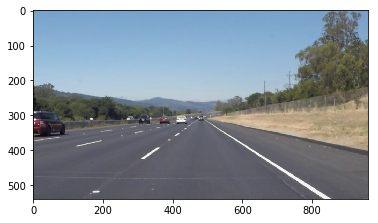

In [17]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [18]:
import math

# Convert image to greyscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Applies the Canny tranform for edge detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# Applies gaussian blur
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Blacks out regions in img defined by vertices
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Draws identified lane lines on image
def extrapolate_lines(imageShape, lines, color=[255, 0, 0], thickness=5):
    # Sort the lines in to left and right lines
    # We also want to filter out 'impossible' lines that have too low a gradient
    # (Beyond the car's turning circle)
    gradientThreshold = 0.45
    leftPoints = []
    leftGradients = []
    rightPoints = []
    rightGradients = []
    filteredLines = []
    
    regionTop = int(imageShape[0] // 1.7)
    regionBottom = imageShape[0]
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            gradient = ((y2 - y1) / (x2 - x1))
            if (gradient > gradientThreshold):
                leftPoints += [(x1, y1, gradient), (x2, y2, gradient)]
                leftGradients += [gradient]
            elif (gradient < -gradientThreshold):
                rightPoints += [(x1, y1, gradient), (x2, y2, gradient)]
                rightGradients += [gradient]

    # Fit a line through the Left points
    if leftPoints:
        leftXYs = list(zip(*leftPoints))
        leftXs = leftXYs[0]
        leftYs = leftXYs[1]

        A = np.vstack([leftXs, np.ones(len(leftXs))]).T
        leftGradient, leftOffset = np.linalg.lstsq(A, leftYs)[0]

        # With the fitted gradient and offset known, construct a line
        leftLineX1 = int((regionBottom - leftOffset) / leftGradient)
        leftLineX2 = int((regionTop - leftOffset) / leftGradient)

        filteredLines += [[[leftLineX1, regionBottom, leftLineX2, regionTop]]]

    # Fit a line through the Right points
    if rightPoints:
        rightXYs = list(zip(*rightPoints))
        rightXs = rightXYs[0]
        rightYs = rightXYs[1]
        A = np.vstack([rightXs, np.ones(len(rightXs))]).T
        rightGradient, rightOffset = np.linalg.lstsq(A, rightYs)[0]
        
        # With the fitted gradient and offset known, construct a line
        rightLineX1 = int((regionBottom - rightOffset) / rightGradient)
        rightLineX2 = int((regionTop - rightOffset) / rightGradient)

        filteredLines += [[[rightLineX1, regionBottom, rightLineX2, regionTop]]]

    return filteredLines

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
# Takes in a Canny-transformed image, and draws Hough lines on it
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Alpha blend two images together
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [19]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve_solution.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

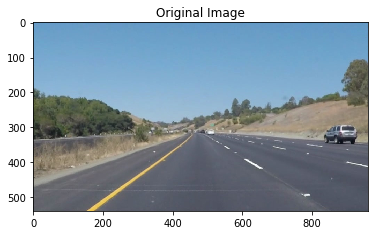

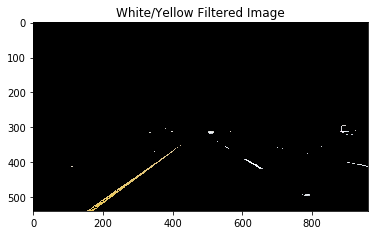

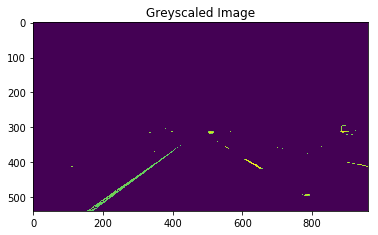

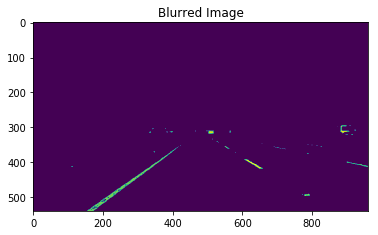

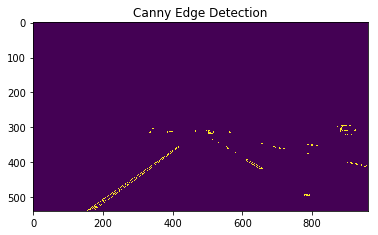

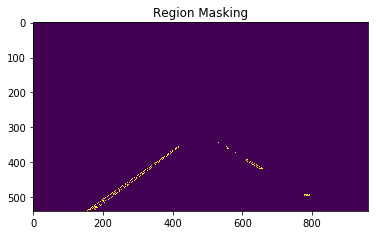

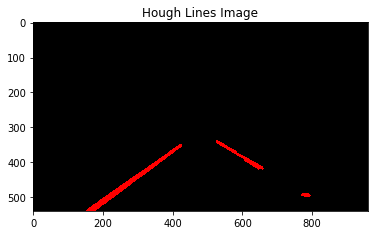

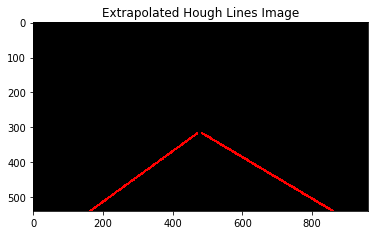

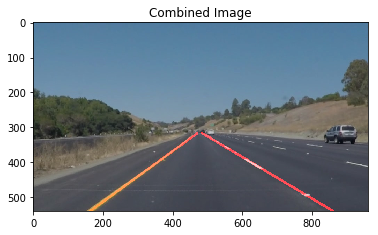

In [20]:
# Specify the read and save file names
readFileName = 'test_images/solidYellowCurve.jpg'
saveFileName = 'test_images/solidYellowCurve_solution.jpg'

# Read the image from file
image = mpimg.imread(readFileName)

# Work on a copy of the image
tempImage = np.copy(image)

# Focus only on certain colours of Yellow and White (likely to be line colors)
# Filter out the rest
yellowFilter = cv2.inRange(tempImage, np.array([200, 93, 61]), np.array([236, 207, 154]))
whiteFilter = cv2.inRange(tempImage, np.array([190,190,190]), np.array([255, 255, 255]))
combinedFilter = cv2.bitwise_or(yellowFilter, whiteFilter)
filteredImage = cv2.bitwise_and(tempImage, tempImage, mask=combinedFilter)

# Convert image to greyscale
grayImage = grayscale(filteredImage)

# Apply gaussian blur to reduce noise
kernelSize = 3
blurGrayImage = gaussian_blur(grayImage, kernelSize)

# Apply Canny transform
lowThreshold = 60 
highThreshold = 180
cannyImage = canny(blurGrayImage, lowThreshold, highThreshold)

# Set up region to masktempImage
imageShape = image.shape
imageWidth = imageShape[1]
imageHeight = imageShape[0]
regionTopLeft = (imageWidth * 0.4, imageHeight / 1.6)
regionTopRight = (imageWidth * 0.6, imageHeight / 1.6)
regionMidLeft = (imageWidth * 0.4, imageHeight / 1.3)
regionMidRight = (imageWidth * 0.6, imageHeight / 1.3)
regionInnerBottomLeft = (imageWidth * 0.3, imageHeight)
regionInnerBottomRight = (imageWidth * 0.7, imageHeight)
regionBottomLeft = (imageWidth * 0.05, imageHeight)
regionBottomRight = (imageWidth * 0.95, imageHeight)
vertices = np.array([[regionTopLeft, regionTopRight, regionBottomRight, regionInnerBottomRight, regionMidRight, regionMidLeft, regionInnerBottomLeft, regionBottomLeft]], dtype=np.int32)

# Apply mask 
maskedImage = region_of_interest(cannyImage, vertices)

# Apply Hough transform to identify lines
rho = 1                 # distance resolution of 1 pixel
theta = np.pi / 180     # angular resolution at 1 degree (in radians)
threshold = 15          # minimum plt.imshow(weightedImage)number of intersections in a hough cell to be considered a line
minLineLength = 15      # minimum length (in pixels) requirement to be considered a line
maxLineGap = 30         # maximum acceptable gap (in pixels) to be tempImageconsidered as part of the same line


# Image with hough lines drawn
houghLines = hough_lines(maskedImage, rho, theta, threshold, minLineLength, maxLineGap)
houghLinesImage = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(houghLinesImage, houghLines)

# Image with extrapolated hough lines
extrapolatedLines = extrapolate_lines(image.shape, houghLines)
extrapolatedLinesImage = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
draw_lines(extrapolatedLinesImage, extrapolatedLines)

# Overlay Hough lines on original image
weightedImage = weighted_img(extrapolatedLinesImage, image)

plt.figure()
plt.title('Original Image')
plt.imshow(tempImage)

plt.figure()
plt.title('White/Yellow Filtered Image')
plt.imshow(filteredImage)

plt.figure()
plt.title('Greyscaled Image')
plt.imshow(grayImage)

plt.figure()
plt.title('Blurred Image')
plt.imshow(blurGrayImage)

plt.figure()
plt.title('Canny Edge Detection')
plt.imshow(cannyImage)

plt.figure()
plt.title('Region Masking')
plt.imshow(maskedImage)

plt.figure()
plt.title('Hough Lines Image')
plt.imshow(houghLinesImage)

plt.figure()
plt.title('Extrapolated Hough Lines Image')
plt.imshow(extrapolatedLinesImage)

plt.figure()
plt.title('Combined Image')
plt.imshow(weightedImage)


plt.savefig(saveFileName)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    # Work on a copy of the image
    tempImage = np.copy(image)

    # Focus only on certain colours of Yellow and White (likely to be line colors)
    # Filter out the rest
    yellowFilter = cv2.inRange(tempImage, np.array([200, 93, 61]), np.array([236, 207, 154]))
    whiteFilter = cv2.inRange(tempImage, np.array([190,190,190]), np.array([255, 255, 255]))
    combinedFilter = cv2.bitwise_or(yellowFilter, whiteFilter)
    maskedImage = cv2.bitwise_and(tempImage, tempImage, mask=combinedFilter)

    # Convert image to greyscale
    grayImage = grayscale(maskedImage)

    # Apply gaussian blur to reduce noise
    kernelSize = 3
    blurGrayImage = gaussian_blur(grayImage, kernelSize)

    # Apply Canny transform
    lowThreshold = 60 
    highThreshold = 180
    cannyImage = canny(blurGrayImage, lowThreshold, highThreshold)

    # Set up region to masktempImage
    imageShape = image.shape
    imageWidth = imageShape[1]
    imageHeight = imageShape[0]
    regionTopLeft = (imageWidth * 0.4, imageHeight / 1.6)
    regionTopRight = (imageWidth * 0.6, imageHeight / 1.6)
    regionMidLeft = (imageWidth * 0.4, imageHeight / 1.3)
    regionMidRight = (imageWidth * 0.6, imageHeight / 1.3)
    regionInnerBottomLeft = (imageWidth * 0.3, imageHeight)
    regionInnerBottomRight = (imageWidth * 0.7, imageHeight)
    regionBottomLeft = (imageWidth * 0.05, imageHeight)
    regionBottomRight = (imageWidth * 0.95, imageHeight)
    vertices = np.array([[regionTopLeft, regionTopRight, regionBottomRight, regionInnerBottomRight, regionMidRight, regionMidLeft, regionInnerBottomLeft, regionBottomLeft]], dtype=np.int32)

    # Apply mask 
    maskedImage = region_of_interest(cannyImage, vertices)

    # Apply Hough transform to identify lines
    rho = 1                 # distance resolution of 1 pixel
    theta = np.pi / 180     # angular resolution at 1 degree (in radians)
    threshold = 15          # minimum number of intersections in a hough cell to be considered a line
    minLineLength = 15      # minimum length (in pixels) requirement to be considered a line
    maxLineGap = 30         # maximum acceptable gap (in pixels) to be tempImageconsidered as part of the same line
    houghLines = hough_lines(maskedImage, rho, theta, threshold, minLineLength, maxLineGap)

    extrapolatedLines = extrapolate_lines(image.shape, houghLines)
    extrapolatedLinesImage = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(extrapolatedLinesImage, extrapolatedLines)

    # Overlay Hough lines on original image
    result = weighted_img(extrapolatedLinesImage, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [23]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 69.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 11.7 s, sys: 328 ms, total: 12 s
Wall time: 3.47 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [25]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 67.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 36.2 s, sys: 853 ms, total: 37 s
Wall time: 10.4 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


----
The algorithm I'm currently using makes an assumption that the lane lines are coloured yellow / white (or somewhere in between). This is a very big assumption, and the algorithm will fail the moment we encounter low light/low contrast conditions, such as during night driving. Another possible source of failure is when the entire landscape has a reddish bright/yellowish hue (for e.g. during sunset).

Also, the fact that the current logic is stateless (does not use information from the previous frames) makes the output somewhat volatile/jerky. The output could be stablized further if I could check if the line gradient change between consecutive frames is too big or too sudden.

Another source of problems is that I'm masking out regions of the image because I'm assuming that the car will always be driving in the middle of the road. That may not always be the case, and crucial information might be incorrectly masked out.

For now, the algorithm seems to find the lanes correctly in all 3 videos (including the challenge video). However, it cannot be called robust. I would not want to sit in a car running this code!

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [29]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:05<00:00, 43.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 15.4 s, sys: 459 ms, total: 15.9 s
Wall time: 6.38 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))